In [1]:
## make sure you have dask-drmaa installed; if not, run pip install dask-drmaa

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from dask.distributed import Client
from fish.util.distributed import get_cluster
from dask.array import coarsen
import dask.array as da
from fish.image.zds import ZDS
import numpy as np

In [3]:
# path to raw data
base_dir = '/nrs/ahrens/davis/data/spim/raw/20160608/6dpf_cy171xcy221_f1_omr_1_20160608_170933/'

# make a ZDS with the path to raw data. this can take a while due to funny issues with accessing hdf5 files
dset = ZDS(base_dir)

# the zds has a data property that is a dask array with 1 chunk : file 
# For this demo I downsample in time
data = dset.data[::10]
print(data)

dask.array<getitem, shape=(500, 37, 2048, 2048), dtype=int16, chunksize=(1, 37, 2048, 2048)>


In [ ]:
# make a filtered version of our raw data
from scipy.ndimage.filters import median_filter
data_filt = data.map_blocks(lambda v: median_filter(v, (1,1,5,5)))    

# take the mean over some filtered images to form a reference image for registration
# 'threads' is the default scheduler, but I set it explicitly for pedagogical purposes
anat_ref = data_filt[data_filt.shape[0]//2 + np.arange(-5,5)].mean(0).compute(scheduler='threads')

In [4]:
# Janelia uses a DRMAA cluster for scheduling jobs.
# dask needs a DRMAACluster object tailored for work on the janelia compute cluster
cluster = get_cluster()

# instantiate a dask.distributed.Client object with that DRMAACluster
client = Client(cluster)

# once we have a client object, it will register itself as the default scheduler, overriding 'threads'. 
# so calling dask_array.compute() with no scheduler specified will try to use the distributed scheduler,
# even if we have no workers requested (in which case, your computation goes nowhere)
client

Client Scheduler: tcp://10.36.107.34:40466 Dashboard: http://10.36.107.34:45736/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
# parallelizable function that estimates translation between two images 
def reg(fixed, moving):
    from fish.image.alignment import estimate_translation    
    from numpy import expand_dims
    affs =  estimate_translation(fixed.squeeze(), moving.squeeze()).affine
    return expand_dims(affs, 0)

# a parallelizable function that applies a 2D shift to an array
def shift_yx(im, shifts, block_id):
    from scipy.ndimage.interpolation import shift
    t = block_id[0]    
    return shift(im.astype('float32'), (0,0, *shifts[t]), order=1, cval=100)

# parallelizable function that takes an array as input and performs efficient df/f along the 0th axis of the vector
def mydff(v):
    from fish.image.vol import dff
    camera_offset = 80
    window = 400
    percentile = 20
    offset = 10    
    downsample = 10;
    return dff((v - camera_offset).clip(1, None), window, percentile, offset, downsample, axis=0).astype('float32')

In [8]:
%%time
# estimate motion
import time
# get 250 workers
# cluster.start_workers(250)

# do nothing for 10s while workers arrive
time.sleep(10)

# Take the max projection of our reference image and distribute it to all our workers using client.scatter
ref_mx_bc = client.scatter(anat_ref.max(0), broadcast=True)

# take the max projection of data_filt along z, then map our registration function to each block.
# it will return a (t, 2, ,2) array where each timepoint is a 2-D affine transform
# overall I find this very ugly, but it works
affines = data_filt.max(1).map_blocks(lambda a,b: reg(b, a), ref_mx_bc, dtype='float32', chunks=(1,2,2)).compute()

# stop the workers
cluster.stop_workers(cluster.workers)

# you should save the affine transforms to disk so you don't have to estimate them every time
# e.g. np.save(reg_path, affines)

# we are going to use scipy.ndimage.interpolation.shift to apply the 2-D translation, 
# so we index into affines to just get the y shift and x shift for each timepoint
# we also have to multiply by -1 to work with the scipy shift function
shifts = -affines[:,:-1,-1]    

CPU times: user 1min 53s, sys: 43.2 s, total: 2min 36s
Wall time: 5min


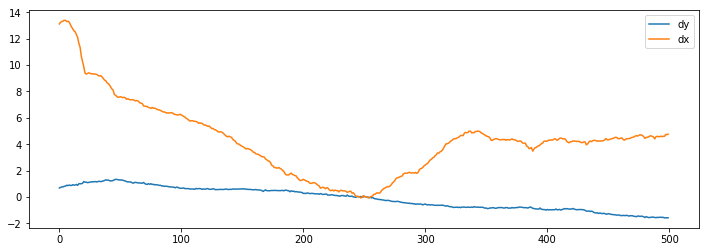

In [9]:
fig, axs = plt.subplots(figsize=(12,4))
axs.plot(shifts)
axs.legend(['dy','dx'])

In [10]:
# shift each timepoint and apply a median filter
data_txf = data.map_blocks(shift_yx, shifts, dtype='float32').map_blocks(lambda v: median_filter(v, size=(1,1,3,3)))

# reduce data size by 16 by downsampling by 4 in x and y 
ds_xy = 4
data_ds = coarsen(np.mean, data_txf, {2: ds_xy, 3: ds_xy})

# now rechunk the data so that each chunk contains an entire timeseries. this is like doing `images.toSeries` in thunder.
rechunked = data_ds.rechunk(chunks=(data_ds.shape[0], 'auto', 'auto','auto'))
data_dff = rechunked.map_blocks(mydff, dtype='float32')

In [11]:
%%time
cluster.start_workers(100)
time.sleep(10)
result = data_dff.max(1).compute()
cluster.stop_workers(cluster.workers)

CPU times: user 3min 1s, sys: 40.2 s, total: 3min 41s
Wall time: 7min 53s


In [16]:
# here's the df/f data
result.shape

(500, 512, 512)

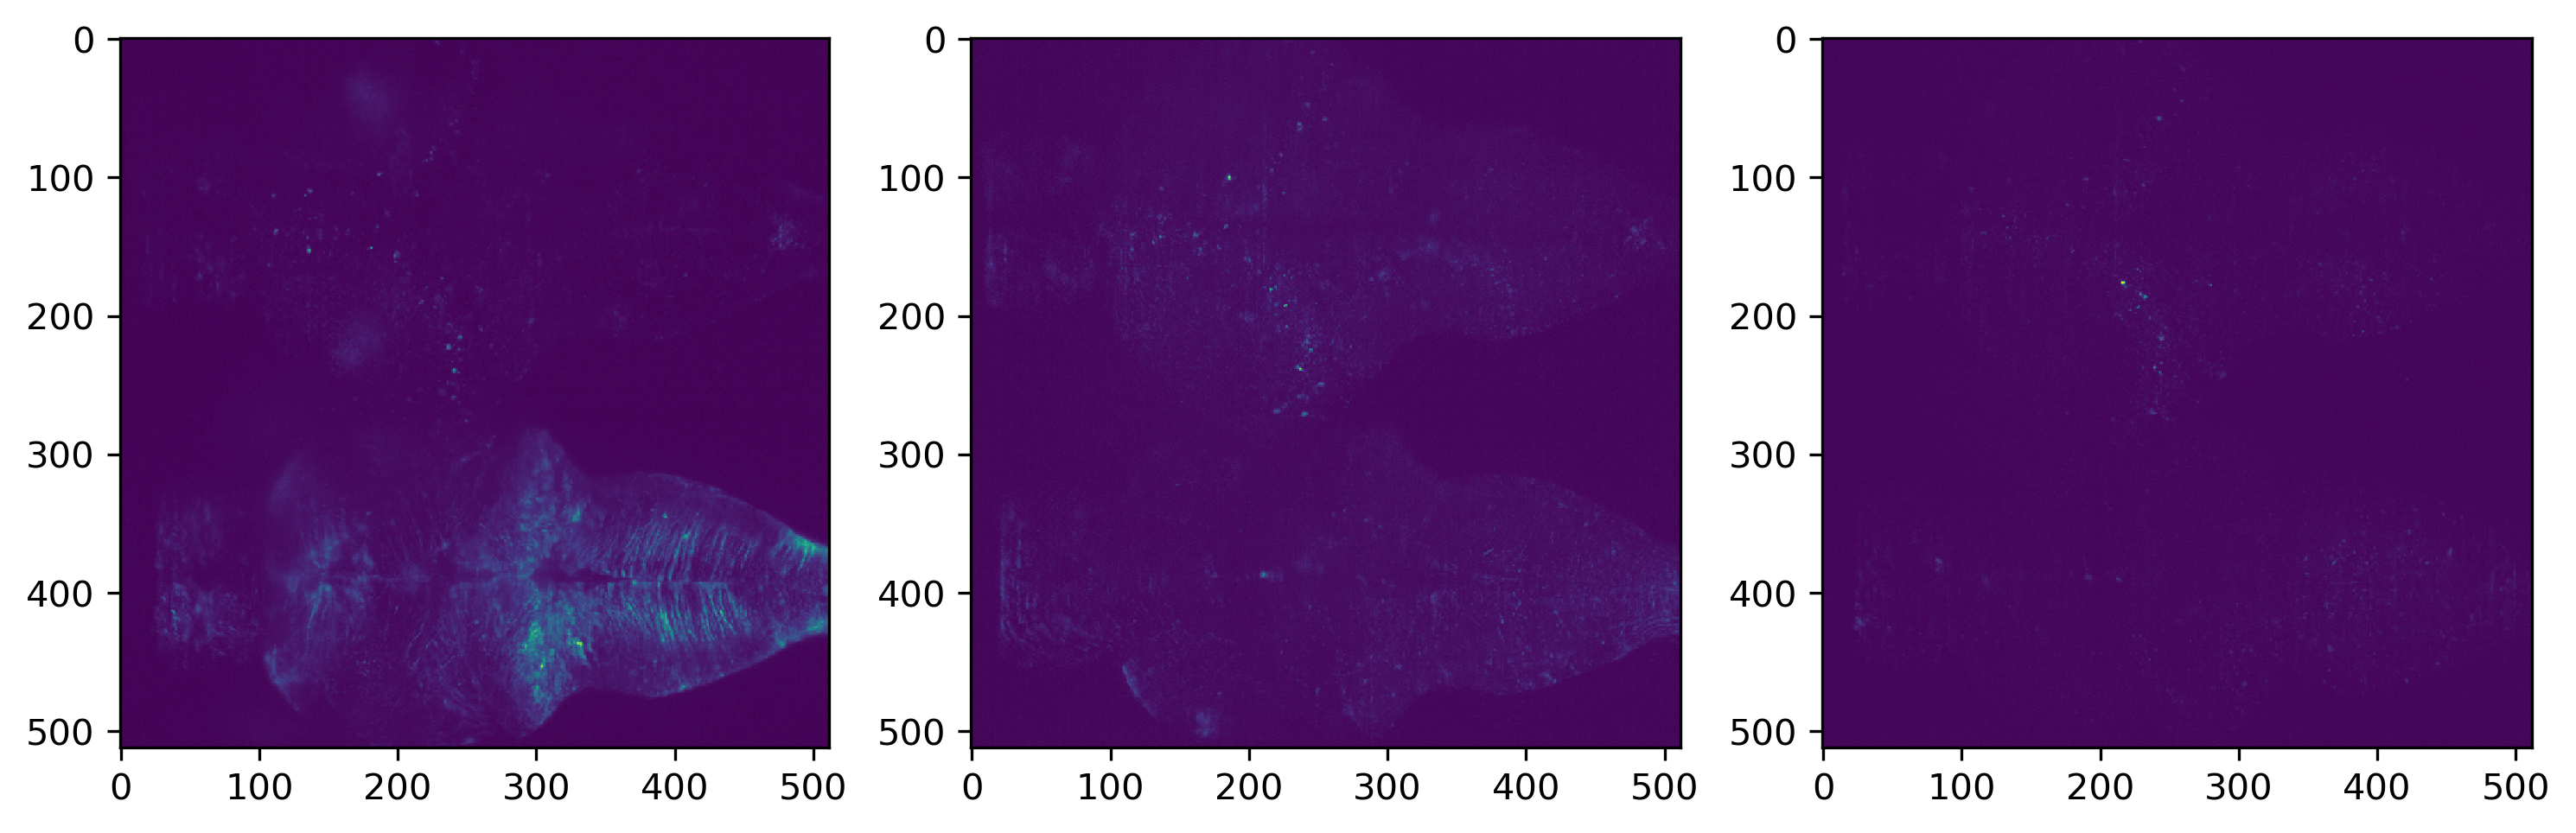

In [15]:
fig, axs = plt.subplots(ncols=3, figsize=(12,4), dpi=300)
[axs[ind].imshow(result[t]) for ind, t in enumerate(np.linspace(0, result.shape[0]-1, len(axs), dtype='int'))]